In [1]:
import os
from pathlib import Path
import re
from tqdm import tqdm

import numpy as np
import pandas as pd

import urbanaccess as ua
import networkx as nx
import osmnx as ox

import logging
from enum import Enum

import networkx as nx
import osmnx as ox
import time
import numpy as np
import pandas as pd
from haversine import haversine
from sklearn.neighbors import BallTree

from zipfile import ZipFile
from ua2nx import urbanaccess_to_nx as ua_to_nx

from urbanaccess.config import settings

EARTH_RADIUS_M = 6_371_009

In [2]:
settings.log_consolse = False

In [3]:
logging.basicConfig()
logger = logging.getLogger('graph_extraction')
logger.setLevel(logging.INFO)

In [4]:
# get the boundaries of Amsterdam
gdf = ox.geocode_to_gdf({'city': 'Amsterdam'})
BBOX_AMS = {
    'west': gdf.loc[0, 'bbox_west'],
    'south': gdf.loc[0, 'bbox_south'],
    'east': gdf.loc[0, 'bbox_east'],
    'north': gdf.loc[0, 'bbox_north']
}

In [23]:
ox.graph_from_bbox(BBOX_AMS['south'], BBOX_AMS['north'], BBOX_AMS['west'], BBOX_AMS['east'], network_type='walk', simplify=True)

Exception ignored on calling ctypes callback function: <function Index._create_idx_from_stream.<locals>.py_next_item at 0x7f55792c8ee0>
Traceback (most recent call last):
  File "/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/rtree/index.py", line 1047, in py_next_item
    p_id[0], coordinates, obj = next(stream_iter)
  File "/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/geopandas/sindex.py", line 409, in <genexpr>
    (i, item.bounds, None)
  File "/home/rico/anaconda3/envs/thesis/lib/python3.9/site-packages/shapely/geometry/point.py", line 153, in bounds
    xy = self.coords[0]
KeyboardInterrupt: 


KeyboardInterrupt: 

TypeError: graph_from_gdfs() missing 1 required positional argument: 'gdf_edges'

# Graph extraction

In [5]:
GTFS_DATA_DIR = Path('./sample_data/gtfs_monday_extracted')
GRAPH_DATA_DIR = Path('./sample_data/graphs')
TMP_DATA_PATH = Path('./tmp')

## OSM Graphs

In [6]:
class OSMNetworkTypes(Enum):
    WALK = 'walk'
    BIKE = 'bike'
    DRIVE = 'drive'

In [7]:
def create_graph_from_osm(bbox: dict, network_type: OSMNetworkTypes, largest_component: bool = False, speed: float = None):
    
    G = ox.graph_from_bbox(
                bbox['north'],
                bbox['south'],
                bbox['east'],
                bbox['west'],
                network_type.value)

    if largest_component:
        G = ox.utils_graph.get_largest_component(G, strongly=True)
    
    if speed:
        nx.set_edge_attributes(G, speed,'speed_kph')
    else:
        G = ox.speed.add_edge_speeds(G, precision=1)

    G = ox.speed.add_edge_travel_times(G, precision=1)

    return G

In [8]:
# Create the graphs
G_walk = create_graph_from_osm(BBOX_AMS, OSMNetworkTypes.WALK, speed=5)
G_bike = create_graph_from_osm(BBOX_AMS, OSMNetworkTypes.BIKE, speed=15)
G_drive = create_graph_from_osm(BBOX_AMS, OSMNetworkTypes.DRIVE, largest_component=True)

KeyboardInterrupt: 

In [ ]:
# fig, ax = ox.plot_graph(G_drive, node_size=3)
# fig.savefig('./images/amsterdam_drive_network.png')

# fig, ax = ox.plot_graph(G_bike, node_size=3)
# fig.savefig('./images/amsterdam_bike_network.png')

# fig, ax = ox.plot_graph(G_walk, node_size=3)
# fig.savefig('./images/amsterdam_walk_network.png')

## Load GTFS

In [9]:
all_gtfs_files = [GTFS_DATA_DIR.joinpath(e) for e in os.listdir(GTFS_DATA_DIR) if Path(e).suffix == '.zip']

## Helper functions

In [10]:
def append_length_attribute(ua_network):
    """ UrbanAccess networks do not have a 'length' attribute (they have 'weight' instead.)
    We want to add the length attribute because it is needed for some osmnx methods. 
    We will set it to the same value as the weight.
    Args:
        ua_network (urbanaccess.network.urbanaccess_network):

    Returns:
        urbanaccess.network.urbanaccess_network: [description]
    """
    ua_network_weights = {}
    for node1, node2, key, data in ua_network.edges(data=True, keys=True):
        ua_network_weights[(node1, node2, key)] = data['weight']

    nx.set_edge_attributes(ua_network, ua_network_weights, "length")
    nx.set_edge_attributes(ua_network, ua_network_weights, "travel_time")

    return ua_network

In [11]:
def parse_nx_node(row, attr, idcol):
    """Parses nodes into nx-format"""
    attr = row[attr].copy()
    return (row[idcol], attr.to_dict())

def parse_nx_edge(row, attr_cols, fr, to):
    """Parses edges into nx-format"""
    idx = row.name
    attr = row[attr_cols].copy().to_dict()
    return (row[fr], row[to], idx, attr)

def ua_transit_network_to_nx(transit_net):
    """Convert an urbanaccess transit network to networkx.
    ua2nx needs a transit+walk network to work, thus here the function is adjusted for when
    only a tranist network is available.

    Args:
        transit_net (urbanaccess.network.urbanaccess_network): transit network to convert to networkx.
    """
    nodes = transit_net.transit_nodes
    edges = transit_net.transit_edges
    graph = nx.MultiDiGraph()

    # Reset index for nodes to get the integer version of the node_id
    nodes = nodes.reset_index()
    fr = 'node_id_from'
    to = 'node_id_to'
    nodeid = 'node_id'

    # Don't make an edge out of every trip, instead aggregate them using the median travel time.
    edges = edges.groupby([fr, to])['weight'].agg('median').reset_index() \
        .merge(edges, on=[fr, to]).rename(columns={'weight' + '_x': 'weight'}) \
        .drop_duplicates([fr, to]) \
        .drop('weight' + '_y', axis=1)
    
    edge_attr=['node_id_from', 'node_id_to', 'weight', 'net_type', 'route_type',
                                    'sequence', 'unique_agency_id', 'unique_route_id',
                                    'unique_trip_id']
    exp_edge_attr = edge_attr
    exp_node_attr = list(nodes.columns)

    nodes['nx_node'] = nodes.apply(parse_nx_node, attr=exp_node_attr, idcol=nodeid, axis=1)
    edges['nx_edge'] = edges.apply(parse_nx_edge, attr_cols=exp_edge_attr, fr=fr, to=to, axis=1)

    graph.add_nodes_from(nodes['nx_node'].to_list())
    graph.add_edges_from(edges['nx_edge'].to_list())

    graph.graph['crs'] = {'init': 'epsg:4326'}
    graph.graph['name'] = edges['unique_agency_id'].unique()[0]

    return graph

In [12]:
def add_transfer_edges(G, headways):
    """ Adds edges between all nodes in the network by taking the avg walking speed/euclidean distance
    between each node. This is done to enable inter-layer edges on transit networks.

    Args:
        G : networkx graph
    """
    def create_edge(orig, dest):
        orig = nodes.iloc[orig]
        dest = nodes.iloc[dest]

        # Do not add loop edges.
        if orig['node_id'] == dest['node_id']:
            return None

        dist = haversine((orig['x'], orig['y']), (dest['x'], dest['y']))
            
        # Only add a new edge if the distance between the nodes is max 1 kilometer
        if dist > 1:
            return None
        
        travel_time = dist/5*60
        # 0 means no connection, we prefer a very small number instead.
        # This is to avoid re-adding an edge after the previous add had weight=0 (check loop below)
        if travel_time == 0:
            travel_time = 0.0001

        # Add headway time if available
        if not np.isnan(dest['mean_hw']):
            travel_time += dest['mean_hw']

        return (
            orig['node_id'],
            dest['node_id'],
            {
                'node_id_from': orig['node_id'],
                'node_id_to': dest['node_id'],
                'length': dist,
                'weight': travel_time,
                'travel_time': travel_time,
                'net_type': 'walking_estimation'
            }
        )

    nodes = ox.graph_to_gdfs(G, edges=False)
    nodes = pd.merge(nodes, headways, how='left', left_on='node_id', right_on='unique_stop_id')

    adj_mx = nx.to_numpy_array(G)

    start_time = time.time()
    edges_to_add = []
    # for i in G.nodes():
    for i, node_i in enumerate(G.nodes()):
        for j, node_j in enumerate(G.nodes()):
            if adj_mx[i][j] == 0:
                new_edge = create_edge(i, j)
                if new_edge:
                    edges_to_add.append(new_edge)
                    adj_mx[i][j] = new_edge[2]['weight']
            if adj_mx[j][i] == 0:
                new_edge = create_edge(j, i)
                if new_edge:
                    edges_to_add.append(new_edge)
                    adj_mx[j][i] = new_edge[2]['weight']
            
            print(f'\r Completed: {len(edges_to_add)} paths.', end='')

    G.add_edges_from(edges_to_add)
    print(f'Total time to connect the network: {round((time.time() - start_time)/60, 2)} minutes')
    return G, edges_to_add


## Compute graph from GTFS

In [15]:
path = all_gtfs_files[0]

# (lng_max, lat_min, lng_min, lat_max)
bbox = (
    gdf.loc[0, 'bbox_west'],
    gdf.loc[0, 'bbox_south'],
    gdf.loc[0, 'bbox_east'],
    gdf.loc[0, 'bbox_north'],
)

with ZipFile(path) as ref:
    ref.extractall(TMP_DATA_PATH)
    loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=str(TMP_DATA_PATH.absolute()), 
                                               validation=True, 
                                               verbose=True,
                                               bbox=bbox, 
                                               remove_stops_outsidebbox=True,
                                               append_definitions=True)
    for f in os.listdir(TMP_DATA_PATH):
        os.remove(TMP_DATA_PATH.joinpath(f))

INFO:urbanaccess:Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
INFO:urbanaccess:GTFS text file header whitespace check completed. Took 0.02 seconds
INFO:urbanaccess:--------------------------------
INFO:urbanaccess:Processing GTFS feed: tmp


Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.02 seconds
--------------------------------
Processing GTFS feed: tmp


INFO:urbanaccess:GTFS feed: tmp, calendar_dates uses the same service_id across multiple agency_ids. This feed calendar_dates table will be modified from its original format to provide service_ids for each agency using a one to many join


GTFS feed: tmp, calendar_dates uses the same service_id across multiple agency_ids. This feed calendar_dates table will be modified from its original format to provide service_ids for each agency using a one to many join


INFO:urbanaccess:GTFS feed: tmp, stops uses the same stop_id across multiple agency_ids. This feed stops table will be modified from its original format to provide stop_ids for each agency using a one to many join


GTFS feed: tmp, stops uses the same stop_id across multiple agency_ids. This feed stops table will be modified from its original format to provide stop_ids for each agency using a one to many join


INFO:urbanaccess:agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
INFO:urbanaccess:Unique agency id operation complete. Took 0.67 seconds
INFO:urbanaccess:Unique GTFS feed id operation complete. Took 0.00 seconds
INFO:urbanaccess:Records:
INFO:urbanaccess:              stop_id  unique_agency_id             stop_name stop_code  \
0      stoparea:37036               nan          Lille Europe    lillee   
1      stoparea:18059               nan  Groningen Europapark      gerp   
2     stoparea:111951               nan        Bunde (Westf.)    buende   
3     stoparea:345453               nan   Amersfoort Centraal       amf   
4     stoparea:112037               nan   Monchengladbach Hbf      mcgb   
...               ...               ...                   ...       ...   
3059          2323664                ns                 Gouda       NaN   
3061          2422231                ns        

agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
Unique agency id operation complete. Took 0.67 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
Records:
              stop_id  unique_agency_id             stop_name stop_code  \
0      stoparea:37036               nan          Lille Europe    lillee   
1      stoparea:18059               nan  Groningen Europapark      gerp   
2     stoparea:111951               nan        Bunde (Westf.)    buende   
3     stoparea:345453               nan   Amersfoort Centraal       amf   
4     stoparea:112037               nan   Monchengladbach Hbf      mcgb   
...               ...               ...                   ...       ...   
3059          2323664                ns                 Gouda       NaN   
3061          2422231                ns              Voorhout       NaN   
3063          2323806  ns_international               Hen

INFO:urbanaccess:--------------------------------
INFO:urbanaccess:Added descriptive definitions to stops, routes, stop_times, and trips tables


--------------------------------
Added descriptive definitions to stops, routes, stop_times, and trips tables


INFO:urbanaccess:Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 0.25 seconds
INFO:urbanaccess:1 GTFS feed file(s) successfully read as dataframes:
INFO:urbanaccess:     tmp
INFO:urbanaccess:     Took 1.38 seconds


Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 0.25 seconds
1 GTFS feed file(s) successfully read as dataframes:
     tmp
     Took 1.38 seconds


In [22]:
loaded_feeds.calendar_dates['date'].unique()[0]

numpy.int64

In [12]:
# print(loaded_feeds.stops.head())
# print(loaded_feeds.stops.unique_agency_id.unique())
# print(loaded_feeds.routes.head())
# print(loaded_feeds.stop_times.head())
# print(loaded_feeds.trips.head())
# print(loaded_feeds.calendar.head())

# loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

In [13]:
# Create the transit network graph from GTFS feeds using the urbanaccess library 
transit_net = ua.gtfs.network.create_transit_net(
    gtfsfeeds_dfs=loaded_feeds,
    calendar_dates_lookup={'unique_feed_id': 'tmp_1'},
    day='monday',
    timerange=['07:00:00', '09:00:00'],
)
# Note - this needs to be done after create_transit_net because that's when
# stop_times_int is calculated. This means that G_transit does not currently
# contain headway information in its calculations.
loaded_feeds = ua.gtfs.headways.headways(loaded_feeds,
                                         headway_timerange=['07:00:00', '09:00:00'])

# Calculate average headways by stop
hw = loaded_feeds.headways.drop_duplicates()
hw['mean_sum'] = hw['count'] * hw['mean']

hw = hw.groupby('unique_stop_id')[['mean_sum', 'count']].sum().reset_index()
hw['mean_hw'] = hw['mean_sum']/hw['count'] / 2.0 # TODO: figure out - I am not sure why /2 but they also do it in urban access.
hw = hw[['unique_stop_id', 'mean_hw']]

NameError: name 'loaded_feeds' is not defined

INFO:urbanaccess:Figure created. Took 0.68 seconds


Figure created. Took 0.68 seconds


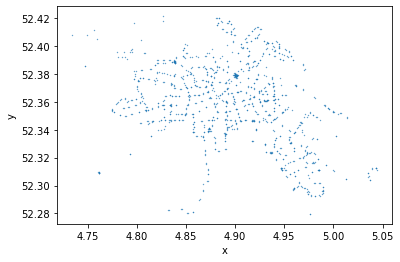

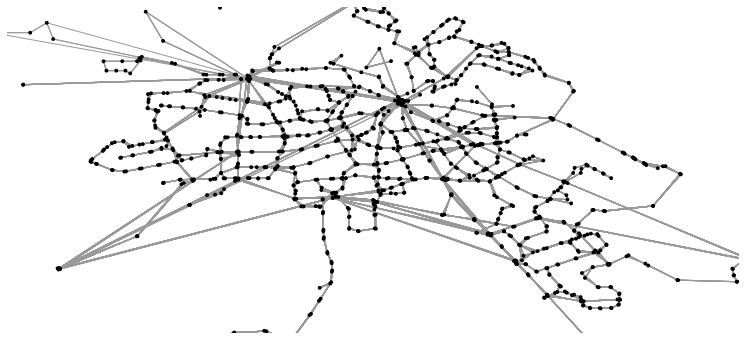

(<Figure size 943.644x432 with 1 Axes>, <AxesSubplot:>)

In [14]:
transit_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)
ua.plot.plot_net(transit_net.transit_nodes, transit_net.transit_edges)

In [15]:
G_transit = ua_transit_network_to_nx(transit_net)
G_transit = append_length_attribute(G_transit)

In [31]:
G_transit.nodes(data=True)['2422355_ns']

{'node_id': '2422355_ns',
 'x': 4.747019,
 'y': 52.385901,
 'unique_agency_id': 'ns',
 'route_type': 2.0,
 'stop_id': '2422355',
 'stop_name': 'Halfweg-Zwanenburg',
 'parent_station': 'stoparea:18248',
 'stop_code': nan,
 'wheelchair_boarding': 0,
 'zone_id': 'IFF:hwzb',
 'location_type': 0,
 'net_type': 'transit',
 'freq': 0}

In [32]:
type(G_transit)

networkx.classes.multidigraph.MultiDiGraph

In [18]:
list(G_transit.edges)

[('2422355_ns', '2422037_ns', 16952),
 ('2323539_ns', '2422316_ns', 15271),
 ('2323216_ns', '2422149_ns', 15208),
 ('2422022_ns', '2422032_ns', 16700),
 ('2422022_ns', '2422033_ns', 16701),
 ('2422036_ns', '2422356_ns', 16798),
 ('2436695_gvb', '2404462_gvb', 17315),
 ('2436694_gvb', '2436695_gvb', 17307),
 ('2436693_gvb', '1690104_gvb', 17300),
 ('2432359_ns', '2422212_ns', 17297),
 ('2324702_ns', '2323487_ns', 15317),
 ('2324702_ns', '2422317_ns', 15321),
 ('2422145_ns', '2323216_ns', 16822),
 ('2422145_ns', '2323222_ns', 16824),
 ('2422145_ns', '2422009_ns', 16825),
 ('2422145_ns', '2422026_ns', 16828),
 ('2422145_ns', '2422027_ns', 16839),
 ('2422145_ns_international', '2323217_ns_international', 16847),
 ('2422145_ns_international', '2422006_ns_international', 16848),
 ('2323487_ns', '2422290_ns', 15263),
 ('2422280_ns', '2323541_ns', 16899),
 ('2422212_ns', '2323199_ns', 16884),
 ('2404452_gvb', '1538698_gvb', 16174),
 ('2422317_ns', '2323540_ns', 16944),
 ('2323540_ns', '2324270

In [15]:
def add_transfer_edges_fast(G, headways):
    adj_mat = nx.to_numpy_array(G)

    nodes = ox.graph_to_gdfs(G, edges=False)
    nodes = pd.merge(nodes, headways, how='left', left_on='node_id', right_on='unique_stop_id')

    ndf = nodes[["y","x"]]
    ndf["yx"] = ndf.apply(tuple, axis=1)

    import itertools
    a = list(itertools.product(ndf["yx"], ndf["yx"]))

    def hav(args):
        return haversine(args[0], args[1])

    hav_mat = np.array(list(map(hav, a))).reshape(adj_mat.shape)

    # Convert distance to travel_time
    travel_time = hav_mat/5*60
    # Set travel_time to more than 0
    travel_time[travel_time==0] = 0.0001

    node_ids_list = nodes['node_id'].to_list()
    dest_node_ids = node_ids_list*len(node_ids_list)
    orig_node_ids = np.array([[n]*len(node_ids_list) for n in node_ids_list]).flatten().tolist()
    fitting_travel_times = travel_time.reshape(-1)
    adjacencies = adj_mat.reshape(-1)
    dist = hav_mat.reshape(-1)
    net_type = ['walking_estimation']*len(dist)

    np.testing.assert_equal([len(dest_node_ids),len(orig_node_ids),len(fitting_travel_times),len(adjacencies),len(dist),len(net_type)], [len(adjacencies)]*6)

    new_edges_dict = {
        'node_id_from': orig_node_ids,
        'node_id_to': dest_node_ids,
        'length': dist,
        'weight': fitting_travel_times,
        'travel_time': fitting_travel_times,
        'net_type': net_type,
        'adjacencies': adjacencies
    }

    new_edges = pd.DataFrame(new_edges_dict)

    # Fix orig['node_id'] == dest['node_id']
    new_edges = new_edges[new_edges['node_id_from']!=new_edges['node_id_to']]

    # Fix dist > 1
    new_edges = new_edges[new_edges['length'] > 1]
    
    # Fix adj_mx[i][j] == 0; adj_mx[j][i] == 0:
    new_edges = new_edges[new_edges['adjacencies'] == 0]

    # Add headway time if available
    new_edges = pd.merge(new_edges, hw.fillna(0), how='left', left_on='node_id_to', right_on='unique_stop_id')
    new_edges["weight"] = new_edges["weight"] + new_edges["mean_hw"]
    new_edges["length"] = new_edges["length"] + new_edges["mean_hw"]
    new_edges = new_edges.drop(["unique_stop_id","mean_hw", 'adjacencies'],1)
    
    # G.add_edges_from(edges_to_add)

    # Convert to entries for new graph edges
    return new_edges.to_dict(orient='records')

In [15]:
# Takes FOREVER!
G_transit_slow, edges_to_add_slow = add_transfer_edges(G_transit, hw)

 Completed: 24104 paths.Total time to connect the network: 6.29 minutes


In [16]:
# Hopefully does the right thing
edges_to_add_fast = add_transfer_edges_fast(G_transit, hw)

In [38]:
edges_to_add_slow == edges_to_add_fast

False

In [40]:
len(edges_to_add_slow)

24104

In [17]:
len(edges_to_add_fast)

1467921

In [ ]:
nx.write_gpickle(G_drive, './graphs/ams_drive_network.gpickle')
nx.write_gpickle(G_bike, './graphs/ams_bike_network.gpickle')
nx.write_gpickle(G_walk, './graphs/ams_walk_network.gpickle')

nx.write_gpickle(G_transit, './graphs/ams_transit_network_transfer_hw_correct.gpickle')
nx.write_gpickle(G_transit_walk, './graphs/ams_transit_walk_network.gpickle')

# GML files are used to read networks into igraph
nx.write_gml(G_transit, './graphs/ams_transit_network_transfer_hw_correct.gml')
nx.write_gml(G_transit_walk, './graphs/ams_transit_walk_network.gml')

In [ ]:
# Add walking network to the transit network.
osm_nodes, osm_edges = ua.osm.load.ua_network_from_bbox(bbox=bbox)

ua_network = ua.osm.network.create_osm_net(
    osm_edges=osm_edges,
    osm_nodes=osm_nodes,
    travel_speed_mph=3,
    network_type='walk')

urbanaccess_nw = ua.network.integrate_network(
    urbanaccess_network=ua_network,
    urbanaccess_gtfsfeeds_df=loaded_feeds,
    headways=True,
    headway_statistic='mean'
    )

In [ ]:
G_transit_walk = ua_to_nx(urbanaccess_nw, optimize='median')
G_transit_walk = append_length_attribute(G_transit_walk)

In [ ]:
# %% Save Graphs
# nx.write_gpickle(G_drive, './graphs/ams_drive_network.gpickle')
# nx.write_gpickle(G_bike, './graphs/ams_bike_network.gpickle')
# nx.write_gpickle(G_walk, './graphs/ams_walk_network.gpickle')

nx.write_gpickle(G_transit, GRAPH_DATA_DIR.joinpath('ams_transit_network_transfer_hw_correct.gpickle'))
nx.write_gpickle(G_transit_walk, GRAPH_DATA_DIR.joinpath('ams_transit_walk_network.gpickle'))

# GML files are used to read networks into igraph
nx.write_gml(G_transit, GRAPH_DATA_DIR.joinpath('ams_transit_network_transfer_hw_correct.gml'))
nx.write_gml(G_transit_walk, GRAPH_DATA_DIR.joinpath('ams_transit_walk_network.gml'))

In [ ]:
# fig, ax = ox.plot_graph(G_transit, node_size=3)
# fig.savefig('./images/amsterdam_transit_network.png')

# For node colouring
# nc = ['r' if node in (2094064399, 46408191) else 'w' for node in G.nodes()]